In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
from matplotlib.colors import ListedColormap

import re

In [539]:
colors = ListedColormap(sns.color_palette('deep')).colors

arousal_color = colors[0]
valence_color = colors[1]

In [540]:
bg_color = ListedColormap(sns.color_palette('Greys', 4)).colors[0]

In [596]:
signal_color = ListedColormap(sns.color_palette('Greens', 4)).colors[1]

In [597]:
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.8
plt.rcParams['grid.linestyle'] = 'dotted'
plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams['figure.figsize'] = (4.845, 3.135)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['mathtext.default']='regular'

In [684]:
from scipy.signal import detrend, butter, sosfilt, lfilter

def lowpass_filter(data, cutoff):
    sos = butter(5, cutoff, analog=False, btype='low', output='sos', fs=1e3)
    return sosfilt(sos, data)

In [685]:
def butter_lowpass(cutoff, fs, order=5):
    return butter(order, cutoff, fs=fs, btype='low', analog=False)

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

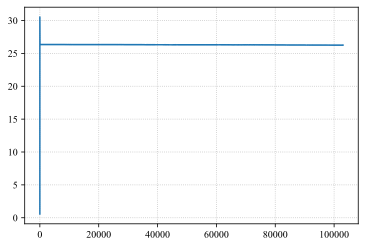

In [695]:
# original (run up to cell 15 before running this)
plt.plot(butter_lowpass_filter(X['skt'].to_numpy(), 200, 1e3))
plt.show()

In [ ]:
def filterTemperature(data):
    offset = data[0]
    return butter_lowpass_filter(
    # remove offset from 0 before filtering to avoid large filter swinging
    (data-offset), 1, 1e3 # filter at 1 Hz with a sampling rate of 1000Hz 
    )+offset # re-apply offset

In [ ]:
plt.plot(X['skt'], label='temperatur signal')
plt.plot(filterTemperature(X['skt']), label='filtered')
plt.legend()
plt.show()

In [ ]:
filtered = filterTemperature(X['skt'])
# test temperature change (difference between samples)
plt.plot(np.concatenate([[0], np.diff(filtered)])) # add 0 at beginning, to keep same length
np.diff(filterTemperature(X['skt'])).std()

## scenario 1

training set and test set have the same subjects and videos

In [604]:
path_prefix = '../'
class S1():
    def __init__(self):
        filenames = sorted(os.listdir(os.path.join(path_prefix, f'data/scenario_1/train/physiology')),
                           key=lambda s: (int(re.findall(r'(?<=sub_)\d+', s)[0]), int(re.findall(r'(?<=vid_)\d+', s)[0])))
        self.subs = list(set([int(re.findall(r'(?<=sub_)\d+', s)[0]) for s in filenames]))
        self.vids = list(set([int(re.findall(r'(?<=vid_)\d+', s)[0]) for s in filenames]))
        self.keys = ['ecg',' bvp', 'gsr', 'rsp', 'skt', 'emg_zygo', 'emg_coru', 'emg_trap']
    
    def train_data(self, sub: int, vid: int, features):
        if len(features) == 0:
            features = self.keys
        return pd.read_csv(os.path.join(path_prefix, f'data/scenario_1/train/physiology', f'sub_{sub}_vid_{vid}.csv'), index_col="time")[features], \
            pd.read_csv(os.path.join(path_prefix, f'data/scenario_1/train/annotations', f'sub_{sub}_vid_{vid}.csv'), index_col="time")
    
    def test_data(self, sub: int, vid: int, features):
        if len(features) == 0:
            features = self.keys
        return pd.read_csv(os.path.join(path_prefix, f'data/scenario_1/test/physiology', f'sub_{sub}_vid_{vid}.csv'), index_col="time")[features], \
            pd.read_csv(os.path.join(path_prefix, f'data/scenario_1/test/annotations', f'sub_{sub}_vid_{vid}.csv'), index_col="time")

In [605]:
s1 = S1()

In [606]:
np.array(s1.subs), np.array(s1.vids)

(array([ 1,  4,  6,  7,  8,  9, 11, 12, 13, 14, 17, 18, 19, 20, 22, 26, 28,
        29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 41, 43, 45]),
 array([ 1,  9, 10, 11, 13, 14, 18, 20]))

In [607]:
sub, vid = 1, 1

In [608]:
X, y = s1.train_data(sub, vid, ['skt'])
_X, _y = s1.test_data(sub, vid, ['skt'])

In [661]:
feature = 'skt'

s1 = S1()
n_vids = len(s1.vids)
n_subs = len(s1.subs)

for i, sub in enumerate(s1.subs):
    fig = plt.figure(figsize=(18, 4 * n_vids))
    fig.patch.set_facecolor('white')
    for j, vid in enumerate(s1.vids):
        train_physiology, train_annotations = s1.train_data(sub, vid, [feature])
        test_physiology, test_annotations = s1.test_data(sub, vid, [feature])

        gap = train_physiology.index[-1] + 20000
        ticks = list(range(0, train_annotations.index[-1] + 1, 20000)) + list(range(gap, gap + test_annotations.index[-1] + 1, 20000))
        labels = list(range(0, train_annotations.index[-1] + 1, 20000)) + list(range(0, test_annotations.index[-1] + 1, 20000))

        ax = plt.subplot(n_vids, 1, j + 1)
        plt.plot(train_physiology.index, train_physiology[feature], color=signal_color)
        plt.axvspan(train_physiology.index[0], train_annotations.index[-1], color=bg_color, alpha=0.6)

        plt.plot(test_physiology.index + gap, test_physiology[feature], color=signal_color)
        plt.axvspan(test_annotations.index[0] + gap, test_annotations.index[-1] + gap, color=bg_color, alpha=0.6)

        plt.xlim(left=train_physiology.index[0], right=test_physiology.index[-1] + gap)

        plt.xticks(ticks=ticks, labels=labels)
        plt.title(f"Scenario 1: Subject {sub} Video {vid}")
        plt.ylabel(f"Signal value ({feature})")
        plt.xlabel("Time")

        ax2 = ax.twinx()
        ax2.set_ylabel('Annotation value')
        ax2.plot(train_annotations.index, train_annotations['arousal'], label='arousal - train', color=arousal_color)
        ax2.plot(train_annotations.index, train_annotations['valence'], label='valence - train', color=valence_color)
        #     ax2.plot(test_annotations.index + gap, test_annotations['arousal'], label='arousal - test')
        #     ax2.plot(test_annotations.index + gap, test_annotations['valence'], label='valence - test')
        plt.legend()

    plt.tight_layout()
    plt.savefig(f'../figures/scenario_1/skt/sub_{sub}.pdf', format='pdf', dpi=300)
    plt.close();
#     plt.show()

## scenario 2

In [723]:
path_prefix = '../'
class S2():
    def __init__(self):
        self.fold = [0, 1, 2, 3, 4]
        
        self.train_subs = [] # (5, x)
        self.test_subs = [] # (5, x)
        self.vids = [] # (x)
        
        for i in self.fold:
            filenames = os.listdir(os.path.join(path_prefix, f'data/scenario_2/fold_{i}/train/physiology'))
            self.train_subs.append(sorted(list(set([int(re.findall(r'(?<=sub_)\d+', s)[0]) for s in filenames]))))
            if self.vids == []:
                self.vids = sorted(list(set([int(re.findall(r'(?<=vid_)\d+', s)[0]) for s in filenames])))
            
            filenames = os.listdir(os.path.join(path_prefix, f'data/scenario_2/fold_{i}/test/physiology'))
            self.test_subs.append(sorted(list(set([int(re.findall(r'(?<=sub_)\d+', s)[0]) for s in filenames]))))

        self.keys = ['ecg',' bvp', 'gsr', 'rsp', 'skt', 'emg_zygo', 'emg_coru', 'emg_trap']
    
    def train_data(self, fold: int, sub: int, vid: int, features=[]):
        if len(features) == 0:
            features = self.keys
        return pd.read_csv(os.path.join(path_prefix, f'data/scenario_2/fold_{fold}/train/physiology', f'sub_{sub}_vid_{vid}.csv'), index_col="time")[features], \
            pd.read_csv(os.path.join(path_prefix, f'data/scenario_2/fold_{fold}/train/annotations', f'sub_{sub}_vid_{vid}.csv'), index_col="time")
    
    def test_data(self, fold: int, sub: int, vid: int, features=[]):
        if len(features) == 0:
            features = self.keys
        return pd.read_csv(os.path.join(path_prefix, f'data/scenario_2/fold_{fold}/test/physiology', f'sub_{sub}_vid_{vid}.csv'), index_col="time")[features], \
            pd.read_csv(os.path.join(path_prefix, f'data/scenario_2/fold_{fold}/test/annotations', f'sub_{sub}_vid_{vid}.csv'), index_col="time")

In [724]:
s2 = S2()

In [725]:
len(s2.fold), len(s2.train_subs[0]), len(s2.test_subs[0]), len(s2.vids)

(5, 24, 6, 8)

In [727]:
feature = 'skt'

s2 = S2()
n_vids = len(s2.vids)

# for fold in s2.fold:

for i, vid in enumerate(s2.vids):
    fig = plt.figure(figsize=(10 * 5, 5 * 30)) # (5 fold, 30 subs for each fold)
    fig.patch.set_facecolor('white')
    for fold in s2.fold:
        n_subs = len(s2.train_subs[fold]) + len(s2.test_subs[fold])
        for j, sub in enumerate(s2.train_subs[fold] + s2.test_subs[fold]):
            ax = plt.subplot(30, 5, fold + j * 5 + 1)
            
            if sub in s2.train_subs[fold]:
                mode = 'train'
                physiology, annotations = s2.train_data(fold, sub, vid, [feature])
            else:
                mode = 'test'
                physiology, annotations = s2.test_data(fold, sub, vid, [feature])
            plt.plot(physiology.index, physiology[feature], color=signal_color)
            plt.axvspan(annotations.index[0], annotations.index[-1], color=bg_color, alpha=0.6)

            plt.xlim(left=physiology.index[0], right=physiology.index[-1])

            plt.title(f"Scenario 2: Fold {fold} - Subject {sub} - Video {vid} - ({mode})")
            plt.ylabel(f"Signal value ({feature})")
            plt.xlabel("Time")

            ax2 = ax.twinx()
            ax2.set_ylabel('Annotation value')
            ax2.plot(annotations.index, annotations['arousal'], label='arousal - train', color=arousal_color)
            ax2.plot(annotations.index, annotations['valence'], label='valence - train', color=valence_color)
            plt.legend()

    plt.tight_layout()
    plt.savefig(f'../figures/scenario_2/skt/vid_{vid}.pdf', format='pdf', dpi=300)
    plt.close();
    #     plt.show()

## scenario 3

In [729]:
path_prefix = '../'
class S3():
    def __init__(self):
        self.fold = [0, 1, 2, 3]
        
        self.train_vids = []
        self.test_vids = []
        self.subs = []
        
        for i in self.fold:
            filenames = os.listdir(os.path.join(path_prefix, f'data/scenario_3/fold_{i}/train/physiology'))
            self.train_vids.append(sorted(list(set([int(re.findall(r'(?<=vid_)\d+', s)[0]) for s in filenames]))))
            if self.subs == []:
                self.subs = sorted(list(set([int(re.findall(r'(?<=sub_)\d+', s)[0]) for s in filenames])))
            
            filenames = os.listdir(os.path.join(path_prefix, f'data/scenario_3/fold_{i}/test/physiology'))
            self.test_vids.append(sorted(list(set([int(re.findall(r'(?<=vid_)\d+', s)[0]) for s in filenames]))))

        self.keys = ['ecg',' bvp', 'gsr', 'rsp', 'skt', 'emg_zygo', 'emg_coru', 'emg_trap']
    
    def train_data(self, fold: int, sub: int, vid: int, features):
        if len(features) == 0:
            features = self.keys
        return pd.read_csv(os.path.join(path_prefix, f'data/scenario_3/fold_{fold}/train/physiology', f'sub_{sub}_vid_{vid}.csv'), index_col="time")[features], \
            pd.read_csv(os.path.join(path_prefix, f'data/scenario_3/fold_{fold}/train/annotations', f'sub_{sub}_vid_{vid}.csv'), index_col="time")
    
    def test_data(self, fold: int, sub: int, vid: int, features):
        if len(features) == 0:
            features = self.keys
        return pd.read_csv(os.path.join(path_prefix, f'data/scenario_3/fold_{fold}/test/physiology', f'sub_{sub}_vid_{vid}.csv'), index_col="time")[features], \
            pd.read_csv(os.path.join(path_prefix, f'data/scenario_3/fold_{fold}/test/annotations', f'sub_{sub}_vid_{vid}.csv'), index_col="time")

In [737]:
s3 = S3()
len(s3.fold), s3.train_vids, s3.test_vids, len(s3.subs)

# row: 8 vids
# column: 30 subs

(4,
 [[0, 3, 4, 10, 21, 22],
  [4, 10, 16, 20, 21, 22],
  [0, 3, 4, 16, 20, 21],
  [0, 3, 10, 16, 20, 22]],
 [[16, 20], [0, 3], [10, 22], [4, 21]],
 30)

In [749]:
feature = 'skt'

s3 = S3()
for fold in s3.fold:
    fig = plt.figure(figsize=(10 * 8, 5 * 30))
    fig.patch.set_facecolor('white')
    for i, sub in enumerate(s3.subs):
        for j, vid in enumerate(s3.train_vids[fold]+s3.test_vids[fold]):  
            ax = plt.subplot(30, 8, i * 8 + j + 1)
            if vid in s3.train_vids[fold]:
                mode = 'train'
                physiology, annotations = s3.train_data(fold, sub, vid, [feature])
            else:
                mode = 'test'
                physiology, annotations = s3.test_data(fold, sub, vid, [feature])
            plt.plot(physiology.index, physiology[feature], color=signal_color)
            plt.axvspan(annotations.index[0], annotations.index[-1], color=bg_color, alpha=0.6)

            plt.xlim(left=physiology.index[0], right=physiology.index[-1])

            plt.title(f"Scenario 3: Fold {fold} - Subject {sub} - Video {vid} - ({mode})")
            plt.ylabel(f"Signal value ({feature})")
            plt.xlabel("Time")

            ax2 = ax.twinx()
            ax2.set_ylabel('Annotation value')
            ax2.plot(annotations.index, annotations['arousal'], label='arousal - train', color=arousal_color)
            ax2.plot(annotations.index, annotations['valence'], label='valence - train', color=valence_color)
            plt.legend()

    plt.tight_layout()
    plt.savefig(f'../figures/scenario_3/skt/fold_{fold}.pdf', format='pdf', dpi=300)
    plt.close();
    #     plt.show()

## scenario 4

In [757]:
path_prefix = '../'
class S4():
    def __init__(self):
        self.fold = [0, 1]
        
        self.train_vids = []
        self.test_vids = []
        self.subs = []
        
        for i in self.fold:
            filenames = os.listdir(os.path.join(path_prefix, f'data/scenario_4/fold_{i}/train/physiology'))
            self.train_vids.append(sorted(list(set([int(re.findall(r'(?<=vid_)\d+', s)[0]) for s in filenames]))))
            if self.subs == []:
                self.subs = sorted(list(set([int(re.findall(r'(?<=sub_)\d+', s)[0]) for s in filenames])))
            
            filenames = os.listdir(os.path.join(path_prefix, f'data/scenario_4/fold_{i}/test/physiology'))
            self.test_vids.append(sorted(list(set([int(re.findall(r'(?<=vid_)\d+', s)[0]) for s in filenames]))))

        self.keys = ['ecg',' bvp', 'gsr', 'rsp', 'skt', 'emg_zygo', 'emg_coru', 'emg_trap']
    
    def train_data(self, fold: int, sub: int, vid: int, features):
        if len(features) == 0:
            features = self.keys
        return pd.read_csv(os.path.join(path_prefix, f'data/scenario_4/fold_{fold}/train/physiology', f'sub_{sub}_vid_{vid}.csv'), index_col="time")[features], \
            pd.read_csv(os.path.join(path_prefix, f'data/scenario_4/fold_{fold}/train/annotations', f'sub_{sub}_vid_{vid}.csv'), index_col="time")
    
    def test_data(self, fold: int, sub: int, vid: int, features):
        if len(features) == 0:
            features = self.keys
        return pd.read_csv(os.path.join(path_prefix, f'data/scenario_4/fold_{fold}/test/physiology', f'sub_{sub}_vid_{vid}.csv'), index_col="time")[features], \
            pd.read_csv(os.path.join(path_prefix, f'data/scenario_4/fold_{fold}/test/annotations', f'sub_{sub}_vid_{vid}.csv'), index_col="time")

In [758]:
s4 = S4()
s4.fold, s4.train_vids, s4.test_vids, s4.subs

([0, 1],
 [[3, 16, 19, 20], [0, 9, 12, 15]],
 [[0, 9, 12, 15], [3, 16, 19, 20]],
 [0,
  1,
  2,
  3,
  5,
  6,
  8,
  9,
  10,
  11,
  12,
  16,
  18,
  19,
  20,
  21,
  24,
  25,
  27,
  29,
  30,
  32,
  33,
  34,
  35,
  36,
  38,
  40,
  43,
  44])

In [759]:
[1, 9, ...]
[2, 10, 18, ...]


[2, 10, 18, Ellipsis]

In [761]:
feature = 'skt'

s4 = S4()
fig = plt.figure(figsize=(10 * 8, 5 * 30))
fig.patch.set_facecolor('white')

for fold in s4.fold:
    for i in range(4): # 4 group vids (train, test)
        for j, sub in enumerate(s4.subs):
            train_physiology, train_annotations = s4.train_data(fold, sub, s4.train_vids[fold][i], [feature])
            test_physiology, test_annotations = s4.test_data(fold, sub, s4.test_vids[fold][i], [feature])
            
            gap = train_physiology.index[-1] + 20000
            ticks = list(range(0, train_annotations.index[-1] + 1, 20000)) + list(range(gap, gap + test_annotations.index[-1] + 1, 20000))
            labels = list(range(0, train_annotations.index[-1] + 1, 20000)) + list(range(0, test_annotations.index[-1] + 1, 20000))

            ax = plt.subplot(30, 8, fold * 4 + i + j * 8 + 1)
            plt.plot(train_physiology.index, train_physiology[feature], color=signal_color)
            plt.axvspan(train_physiology.index[0], train_annotations.index[-1], color=bg_color, alpha=0.6)

            plt.plot(test_physiology.index + gap, test_physiology[feature], color=signal_color)
            plt.axvspan(test_annotations.index[0] + gap, test_annotations.index[-1] + gap, color=bg_color, alpha=0.6)

            plt.xlim(left=train_physiology.index[0], right=test_physiology.index[-1] + gap)

            plt.xticks(ticks=ticks, labels=labels)
            plt.title(f"Scenario 4: Subject {sub} Video {s4.train_vids[fold][i]} vs. {s4.test_vids[fold][i]}")
            plt.ylabel(f"Signal value ({feature})")
            plt.xlabel("Time")

            ax2 = ax.twinx()
            ax2.set_ylabel('Annotation value')
            ax2.plot(train_annotations.index, train_annotations['arousal'], label='arousal - train', color=arousal_color)
            ax2.plot(train_annotations.index, train_annotations['valence'], label='valence - train', color=valence_color)
            #     ax2.plot(test_annotations.index + gap, test_annotations['arousal'], label='arousal - test')
            #     ax2.plot(test_annotations.index + gap, test_annotations['valence'], label='valence - test')
            plt.legend()

plt.tight_layout()
plt.savefig(f'../figures/scenario_4/skt.pdf', format='pdf', dpi=300)
plt.close();

In [642]:
def plot_data_comparison(train_physiology, train_annotations, test_physiology, test_annotations):
    fig = plt.figure(figsize=(10,18))
    fig.patch.set_facecolor('white')
    # plot train physiology with annotations range 
    plt.subplot(411)
    plt.plot(train_physiology.index, train_physiology['skt'])
    plt.axvspan(train_annotations.index[0], train_annotations.index[-1], color='green', alpha=0.3)
    plt.xlim(left=train_physiology.index[0], right=train_physiology.index[-1])
    plt.title("Training data")
    plt.ylabel("Signal value")
    plt.xlabel("Time")
    # plot train annotations
    plt.subplot(412)
    plt.plot(train_annotations.index, train_annotations['arousal'], label='arousal - train')
    plt.plot(train_annotations.index, train_annotations['valence'], label='valence - train')
    plt.xlim(left=train_physiology.index[0], right=train_physiology.index[-1])
    plt.legend()
    plt.ylabel("Annotation value")
    plt.xlabel("Time")
    # plot test physiology with annotations range 
    plt.subplot(413)
    plt.plot(test_physiology.index, test_physiology['skt'])
    plt.axvspan(test_annotations.index[0], test_annotations.index[-1], color='green', alpha=0.3)
    plt.xlim(left=test_physiology.index[0], right=test_physiology.index[-1])
    plt.title("Test data")
    plt.ylabel("Signal value")
    plt.xlabel("Time")
    # plot test annotations
    ax = plt.subplot(414)
    plt.plot(test_annotations.index, test_annotations['arousal'], label='arousal - test')
    plt.plot(test_annotations.index, test_annotations['valence'], label='valence - test')
    plt.xlim(left=test_physiology.index[0], right=test_physiology.index[-1])
    plt.yticks([test_annotations['arousal'].iloc[0]], ["NaN"])
    plt.legend()
    plt.ylabel("Annotation value")
    plt.xlabel("Time")
    plt.tight_layout()
    plt.show()

In [ ]:
plot_data_comparison(train_physiology, train_annotations, test_physiology, test_annotations)